# Load Data

In [47]:
import re
import pandas

enron_dataset_file_name = '../../source-data/emails.csv'

def clean_email_body(body):
    return body

with open(enron_dataset_file_name, 'rb') as f_in:
    raw_email_info = f_in.read()

    # Extract features we may potentially want to use (minus email body)
    dates = re.findall(r'\nDate: (.*)', raw_email_info)
    sender_addresses = re.findall(r'\nFrom: (.*)', raw_email_info)
    recipients = re.findall(r'\nTo: (.*)', raw_email_info)
    subjects = re.findall(r'\nSubject: (.*)', raw_email_info)
    sender_names = re.findall(r'\nX-From: (.*)', raw_email_info)
    recipient_names = re.findall(r'\nX-To: ([ A-Za-z]*)', raw_email_info)
    ccs = re.findall(r'\nX-cc: (.*)', raw_email_info)
    bccs = re.findall(r'\nX-bcc: (.*)', raw_email_info)
    filename = re.findall(r'\nX-FileName: (.*)', raw_email_info)
    folders = re.findall(r'"[a-zA-z-]*/(.*)/.*,"Message-ID.*>', raw_email_info)

    # Strip out all features to extract email body
    raw_email_info = re.sub(r'\nDate: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nFrom: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nTo: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nSubject: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-From: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-To: ([ A-Za-z]*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-cc: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-bcc: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-Folder: (.*)', '', raw_email_info)

    raw_email_info = re.sub(r'"file","message"', '', raw_email_info)
    raw_email_info = re.sub(r'\nMime-Version: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nContent-Type: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nContent-Transfer-Encoding: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-Origin: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'\nX-FileName: (.*)', '', raw_email_info)
    raw_email_info = re.sub(r'".*Message-ID.*>', 'file_name_and_message_id', raw_email_info)

    bodies = [clean_email_body(body) for body in raw_email_info.split('file_name_and_message_id')[1:]]

    email_data = zip(dates,
                     sender_addresses,
                     recipients,
                     subjects,
                     sender_names,
                     recipient_names,
                     ccs,
                     bccs,
                     folders,
                     filename,
                     bodies)

    # Stick features into a dataframe to make it easy to query and filter out data
    df = pandas.DataFrame(email_data, columns=['date',
                                               'sender_address',
                                               'recipient',
                                               'subject',
                                               'sender_name',
                                               'recipient_name',
                                               'cc',
                                               'bcc',
                                               'folder',
                                               'filename',
                                               'body'])

In [ ]:
df.head()

# Text Data Cleansing

In [127]:
# from nltk.tokenize import RegexpTokenizer
# from stop_words import get_stop_words
# from nltk.stem.porter import PorterStemmer
# from collections import Counter
# from sklearn.utils import shuffle
# from sklearn.metrics import f1_score
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from gensim import corpora, models
# import gensim
# import numpy as np

In [128]:
# def clean_body_text(body):

#     tokenizer = RegexpTokenizer(r'\w+')

#     # create English stop words list
#     en_stop = get_stop_words('en')

#     # Create p_stemmer of class PorterStemmer
#     p_stemmer = PorterStemmer()

#     # clean and tokenize document string
#     tokens = tokenizer.tokenize(body)

#     # remove all numbers
#     tokens = [x for x in tokens if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
    
#     # remove structural words
#     tokens = [x for x in tokens if len(x) > 1]
#     tokens = [x.lower() for x in tokens]
#     tokens = [x for x in tokens if 'http' not in x]
#     tokens = [x for x in tokens if x not in "_"]
    
#     # remove stop words from tokens
#     stopped_tokens = [i for i in tokens if not i in en_stop]
    
#     # stem tokens
#     stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
#     return stemmed_tokens

# df['body'].apply(clean_body_text)
# df.head()

# Supervised Learning: Per-User Auto-Sorting

## Feature Engineering

### Filter out system folders that are not relevent for sort predictions

In [129]:
# WIP: remove folders that are most likely computer generated
new_df = df[
    (df.folder != '_sent_mail') &
    (df.folder != 'all_documents') &
    (df.folder != 'deleted_items') &
    (df.folder != 'inbox') &
    (df.folder != 'discussion_threads') &
    (df.folder != 'notes_inbox') &
    (df.folder != 'sent_items') &
    (df.folder != 'sent')
]

print df.shape
print new_df.shape
new_df.head(2)

(513954, 11)
(73051, 11)


,date,sender_address,recipient,subject,sender_name,recipient_name,cc,bcc,folder,filename,body
1230,"Tue, 24 Oct 2000 05:16:00 -0700 (PDT)",phillip.allen@enron.com,"Cheryl Wilchynski/HR/Corp/Enron@ENRON, Cindy R...","""""Save the Date"""" - Associate / Analyst Program",Outlook-Migration-Team </O=ENRON/OU=NA/CN=RECI...,,,,contacts,pallen (Non-Privileged).pst,\n\nloan servicing-jessica weeber 800-393-5626...
1231,"Mon, 23 Oct 2000 08:55:00 -0700 (PDT)",phillip.allen@enron.com,"phillip.allen@enron.com, robina.barker-bennett...",,Outlook-Migration-Team </O=ENRON/OU=NA/CN=RECI...,,,,contacts,pallen (Non-Privileged).pst,"\n\nexit mccollough off 410""\n"


### Drop unusable rows, create a new people column

In [130]:
# Drop rows without Subject
new_df = new_df.dropna(subset=['subject', 'body'])
print 'Shape of dataframe: ' + str(new_df.shape)

# Create a new column that merges CC, To, From
new_df['cc'].fillna('', inplace=True)
new_df['bcc'].fillna('', inplace=True)
new_df['sender_address'].fillna('', inplace=True)
new_df['recipient'].fillna('', inplace=True)
new_df['people'] = new_df['sender_address'] + ',' + new_df['cc'] + ',' + new_df['bcc'] + ',' + new_df['recipient']

Shape of dataframe: (73051, 11)


In [132]:
new_df['people'][0:5]

1230    phillip.allen@enron.com,,,Cheryl Wilchynski/HR...
1231    phillip.allen@enron.com,,,phillip.allen@enron....
3026    phillip.allen@enron.com,,,richard.morgan@austi...
3027    phillip.allen@enron.com,strawbale@crest.org,,g...
3028    phillip.allen@enron.com,moore.john.e@worldnet....
Name: people, dtype: object

### Segment data by recipient, to train one model per-user

In [133]:
# Create a new column that merges CC, To, From
def extract_user(text):
    m = re.search(r'^([^\. ]*)[\. ]', text)
    if m:
        return m.group(1)
    return ''

new_df['user'] = new_df['filename'].apply(extract_user)

user_groups = new_df.groupby('user')
users = user_groups.groups.keys()
print 'Number of users in the data set: ' + str(len(users))

Number of users in the data set: 267


In [135]:
new_df['user'][1000:1005]

19859    dbaughm
19860    dbaughm
19861    dbaughm
19862    dbaughm
19863    dbaughm
Name: user, dtype: object

### Run per-user logistic regression, record accuracy

This run includes only subject & people, and uses basic logistic regression



Total number of users analyzed == 97
Average accuracy for Logistic Regression: 0.510636285778


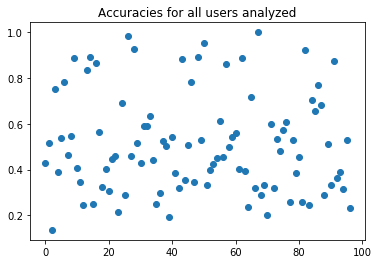

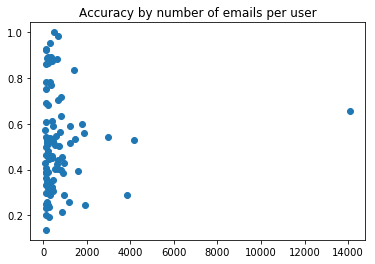

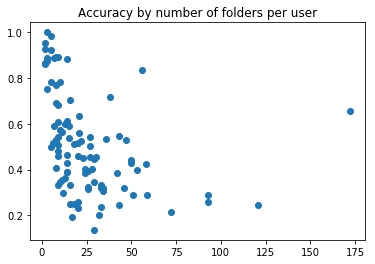

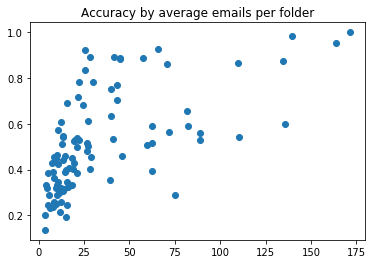

In [122]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from __future__ import division

def people_tokenizer(s):
    people = s.split(',')
    return filter(None, people)

min_email_threshold = 100

num_users = 0
accuracies = []
num_folders = []
num_emails = []
for user, emails in user_groups:
    
#     print '\n' + str(user) + ' has ' + str(len(emails)) + ' emails in the data set.'
#     print '-----------------------------------------------------------------'
    
    # skip over any users with too few emails to analyze
    if len(emails) < min_email_threshold:
        continue
        
    # Perform bag of words vectorization on Subject
    sub_vect = CountVectorizer(stop_words='english', lowercase=True)
    counts = sub_vect.fit_transform(emails['subject'])
#     print 'Dimensions of subject vocabulary feature matrix are: ' + str(counts.shape)

    # Convert Subject from bools to tf-idf values
    tfidf_transformer = TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(counts)

    # Convert people column into email address counts
    people_vec = CountVectorizer(lowercase=True, tokenizer=people_tokenizer)
    people_counts = people_vec.fit_transform(emails['people'])
#     print 'Dimensions of people feature matrix are: ' + str(people_counts.shape)

    # Merge people counts with subject tf-idf
    feature_matrix = scipy.sparse.hstack([people_counts, tfidf])
#     print 'Dimensions of vectorized feature matrix: ' + str(feature_matrix.shape)
    
    # Split into training & test sets
    labels_train, labels_test, features_train, features_test = train_test_split(
        emails['folder'], feature_matrix, test_size=0.20, random_state=42)
#     print 'Size of training feature matrix: ' + str(features_train.shape)
#     print 'Size of test feature matrix: ' + str(features_test.shape)
    
    # Multiclass Logisitic Regression
    lr = LogisticRegression(C=0.1)
    try:
        lr.fit(features_train, labels_train)
    
    # if a user only has emails in a single folder, a ValueError is raised
    # this solver needs samples of at least 2 classes in the data, but the data contains only one class
    except ValueError:
        continue
    test_predict_lr = lr.predict(features_test)
    score_lr = metrics.accuracy_score(y_true=labels_test, y_pred=test_predict_lr)
#     print "Number of emails is " + str(len(emails)) + " for user " + str(user)
#     print "Number of folders is " + str(len(lr.classes_)) + " for user " + str(user)
#     print "Logistic regression accuracy score is " + str(score_lr) + " for user " + str(user)
    
    num_users += 1
    accuracies.append(score_lr)
    num_emails.append(len(emails))
    num_folders.append(len(lr.classes_))
    
print '\n\nTotal number of users analyzed == ' + str(num_users)
print 'Average accuracy for Logistic Regression: ' + str(np.mean(accuracies))

plt.title('Accuracies for all users analyzed')
plt.plot(accuracies, 'o')
plt.show()

plt.title('Accuracy by number of emails per user')
plt.plot(num_emails, accuracies, 'o')
plt.show()

plt.title('Accuracy by number of folders per user')
plt.plot(num_folders, accuracies, 'o')
plt.show()

plt.title('Accuracy by average emails per folder')
plt.plot([x/y for x, y in zip(num_emails, num_folders)], accuracies, 'o')
plt.show()

### Run per-user naive bayes, record accuracy

This run includes only subject & people, and uses basic naive bayes



Total number of users analyzed == 98
Average accuracy for Naive Bayes: 0.615251912778


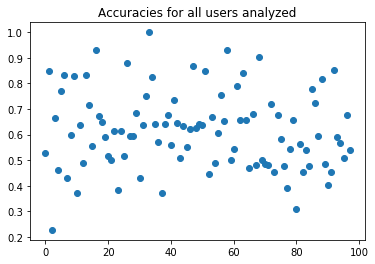

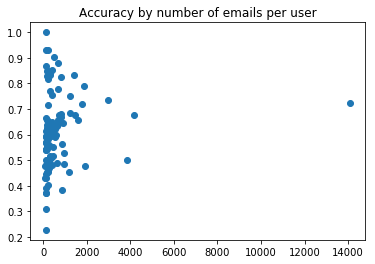

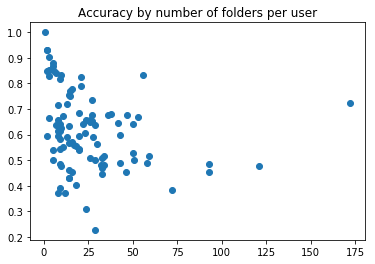

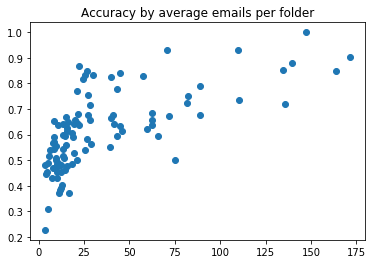

In [120]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy
import numpy as np
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from __future__ import division

def people_tokenizer(s):
    people = s.split(',')
    return filter(None, people)

min_email_threshold = 100

num_users = 0
accuracies = []
num_folders = []
num_emails = []
for user, emails in user_groups:
    
#     print '\n' + str(user) + ' has ' + str(len(emails)) + ' emails in the data set.'
#     print '-----------------------------------------------------------------'
    
    # skip over any users with too few emails to analyze
    if len(emails) < min_email_threshold:
        continue
        
    # Perform bag of words vectorization on Subject
    sub_vect = CountVectorizer(stop_words='english', lowercase=True)
    counts = sub_vect.fit_transform(emails['subject'])
#     print 'Dimensions of subject vocabulary feature matrix are: ' + str(counts.shape)

    # Convert Subject from bools to tf-idf values
    tfidf_transformer = TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(counts)

    # Convert people column into email address counts
    people_vec = CountVectorizer(lowercase=True, tokenizer=people_tokenizer)
    people_counts = people_vec.fit_transform(emails['people'])
#     print 'Dimensions of people feature matrix are: ' + str(people_counts.shape)

    # Merge people counts with subject tf-idf
    feature_matrix = scipy.sparse.hstack([people_counts, tfidf])
#     print 'Dimensions of vectorized feature matrix: ' + str(feature_matrix.shape)
    
    # Split into training & test sets
    labels_train, labels_test, features_train, features_test = train_test_split(
        emails['folder'], feature_matrix, test_size=0.20, random_state=42)
#     print 'Size of training feature matrix: ' + str(features_train.shape)
#     print 'Size of test feature matrix: ' + str(features_test.shape)
    
    ### Multinomial Naive Bayes
    mnb = MultinomialNB(alpha=0.1)
    mnb.fit(features_train, labels_train)
    test_predict_mnb = mnb.predict(features_test)
    score_mnb = metrics.accuracy_score(labels_test, test_predict_mnb)
#     print "Number of emails is " + str(len(emails)) + " for user " + str(user)
#     print "Number of folders is " + str(len(lr.classes_)) + " for user " + str(user)
#     print "Multinomial Naive Bayes accuracy score is: " + str(score_mnb)
        
    num_users += 1
    accuracies.append(score_mnb)
    num_emails.append(len(emails))
    num_folders.append(len(mnb.classes_))
    
print '\n\nTotal number of users analyzed == ' + str(num_users)
print 'Average accuracy for Naive Bayes: ' + str(np.mean(accuracies))

plt.title('Accuracies for all users analyzed')
plt.plot(accuracies, 'o')
plt.show()

plt.title('Accuracy by number of emails per user')
plt.plot(num_emails, accuracies, 'o')
plt.show()

plt.title('Accuracy by number of folders per user')
plt.plot(num_folders, accuracies, 'o')
plt.show()

plt.title('Accuracy by average emails per folder')
plt.plot([x/y for x, y in zip(num_emails, num_folders)], accuracies, 'o')
plt.show()

### Run per-user models, compare accuracies

This run includes only subject & people, and commpares logisitic regression to naive bayes for each user



Total number of users analyzed == 97
Average accuracy: 0.639878147778


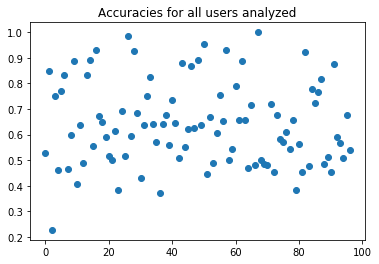

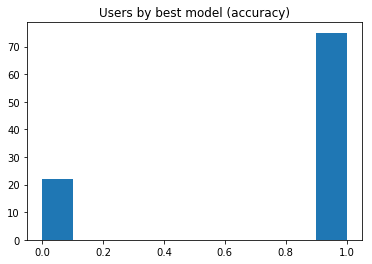

In [123]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy
import numpy as np
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from __future__ import division

def people_tokenizer(s):
    people = s.split(',')
    return filter(None, people)

min_email_threshold = 100

num_users = 0
accuracies = []
num_folders = []
num_emails = []
best_models = []
for user, emails in user_groups:
    
    # skip over any users with too few emails to analyze
    if len(emails) < min_email_threshold:
        continue
        
    # Perform bag of words vectorization on Subject
    sub_vect = CountVectorizer(stop_words='english', lowercase=True)
    counts = sub_vect.fit_transform(emails['subject'])

    # Convert Subject from bools to tf-idf values
    tfidf_transformer = TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(counts)

    # Convert people column into email address counts
    people_vec = CountVectorizer(lowercase=True, tokenizer=people_tokenizer)
    people_counts = people_vec.fit_transform(emails['people'])

    # Merge people counts with subject tf-idf
    feature_matrix = scipy.sparse.hstack([people_counts, tfidf])
    
    # Split into training & test sets
    labels_train, labels_test, features_train, features_test = train_test_split(
        emails['folder'], feature_matrix, test_size=0.20, random_state=42)

    # Multiclass Logisitic Regression
    lr = LogisticRegression(C=0.1)
    try:
        lr.fit(features_train, labels_train)
    
    # if a user only has emails in a single folder, a ValueError is raised
    # this solver needs samples of at least 2 classes in the data, but the data contains only one class
    except ValueError:
        continue
    test_predict_lr = lr.predict(features_test)
    score_lr = metrics.accuracy_score(y_true=labels_test, y_pred=test_predict_lr)
    
    ### Multinomial Naive Bayes
    mnb = MultinomialNB(alpha=0.1)
    mnb.fit(features_train, labels_train)
    test_predict_mnb = mnb.predict(features_test)
    score_mnb = metrics.accuracy_score(labels_test, test_predict_mnb)
        
    best_models.append((0 if score_lr > score_mnb else 1))    
        
    num_users += 1
    accuracies.append((score_lr if score_lr > score_mnb else score_mnb))
    num_emails.append(len(emails))
    num_folders.append(len(mnb.classes_))
    
print '\n\nTotal number of users analyzed == ' + str(num_users)
print 'Average accuracy: ' + str(np.mean(accuracies))

plt.title('Accuracies for all users analyzed')
plt.plot(accuracies, 'o')
plt.show()

plt.title('Users by best model (accuracy)')
plt.hist(best_models)
plt.show()